In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime

In [152]:
nx = 64
L = 1
u_mag = 2
k = np.pi

config = {
    'domain': {
        'minExtent': -L,
        'maxExtent': L,
        'dim': 2,
        'periodic': True
    },
    'particle': {
        'nx': nx
    },
    'compute':{
        'device': 'cuda'
    },
    'fluid':{
        'cs' : u_mag * 10
    },
    'shifting':{
        'scheme': 'deltaSPH',
        'threshold': 0.05,
        'maxIterations': 1,
        'freeSurface': False
    },
}
config = parseDefaultParameters(config)
config = parseModuleParameters(config)

# display(config)

In [153]:
particleState, mask = sampleParticles(config, sdfs = [])

In [191]:
from diffSPH.v2.modules.divergence import computeDivergence
perennialState = copy.deepcopy(particleState)

priorState = None
config['diffusion']['velocityScheme'] = 'deltaSPH_inviscid'
config['diffusion']['nu'] = 0.1

omega = 4

k = np.pi
perennialState['fluidVelocities'][:,0] =  2 * torch.cos(k * perennialState['fluidPositions'][:,0]) * torch.sin(k * perennialState['fluidPositions'][:,1])
perennialState['fluidVelocities'][:,1] = -2 * torch.sin(k * perennialState['fluidPositions'][:,0]) * torch.cos(k * perennialState['fluidPositions'][:,1])

# perennialState['fluidVelocities'][:,0] =  omega * perennialState['fluidPositions'][:,1]
# perennialState['fluidVelocities'][:,1] = -omega * perennialState['fluidPositions'][:,0]
perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)
perennialState['fluidDivergence'] = computeDivergence(perennialState, config)
printState(perennialState)

state[numParticles            ]:       4096	[<class 'int'>]
state[timestep                ]:          0	[<class 'int'>]
state[time                    ]:        0.0	[<class 'float'>]
state[dt                      ]:      0.001	[<class 'float'>]
state[fluidPositions          ]: min: -9.844e-01, max: +9.844e-01, median: -1.562e-02 [torch.Size([4096, 2])	@ cuda:0	x torch.float32	]
state[fluidAreas              ]: min: +9.766e-04, max: +9.766e-04, median: +9.766e-04 [torch.Size([4096])	@ cuda:0	x torch.float32	]
state[fluidPressures          ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([4096])	@ cuda:0	x torch.float32	]
state[fluidDivergence         ]: min: -1.350e-05, max: +1.180e-05, median: +0.000e+00 [torch.Size([4096])	@ cuda:0	x torch.float32	]
state[fluidMasses             ]: min: +9.766e-01, max: +9.766e-01, median: +9.766e-01 [torch.Size([4096])	@ cuda:0	x torch.float32	]
state[fluidSupports           ]: min: +1.186e-01, max: +1.186e-01, median: +1.186e-01 [t

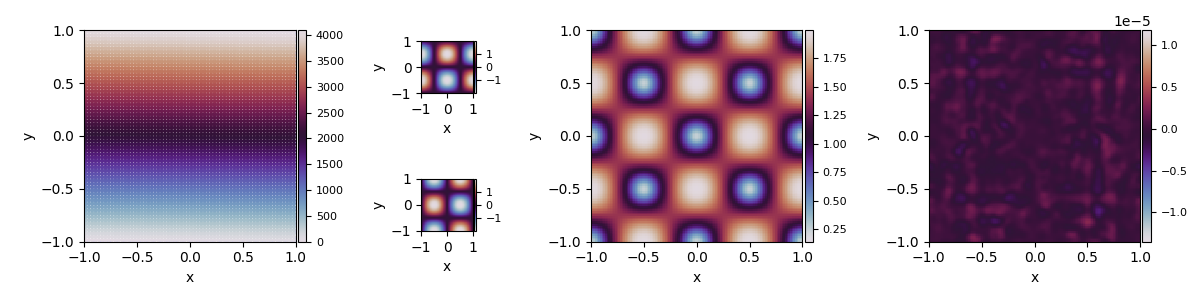

In [192]:
s = 4
fig, axis = plt.subplot_mosaic(\
'''AADBBCC
AAEBBCC''', figsize=(12,3), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)

plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, perennialState['fluidIndex'] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
plotVelUIndex = visualizeParticles(fig, axis['D'], config, visualizationState, perennialState['fluidVelocities'][:,0] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
plotVelVIndex = visualizeParticles(fig, axis['E'], config, visualizationState, perennialState['fluidVelocities'][:,1] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
plotVelMagIndex = visualizeParticles(fig, axis['B'], config, visualizationState, torch.norm(perennialState['fluidVelocities'], dim = 1) , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
plotDivergenceIndex = visualizeParticles(fig, axis['C'], config, visualizationState, perennialState['fluidDivergence'] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')

fig.tight_layout()

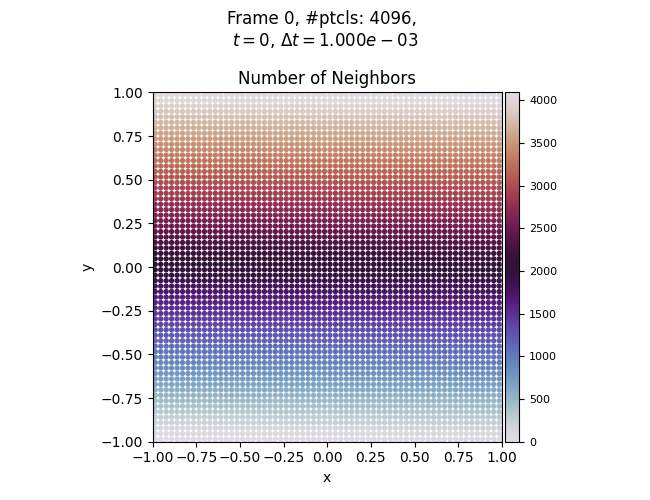

In [193]:
s = 8

fig, axis = plt.subplot_mosaic('''A''', figsize=(6.5,5), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)
# val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
# plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, val , cbar = True, cmap = 'YlGnBu', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
# axis['A'].set_title(r'$P/\rho\omega^2L^2$')

val = perennialState['fluidNumNeighbors']
val = perennialState['fluidIndex']
plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, val , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
axis['A'].set_title(r'Number of Neighbors')

config['timestep']['dt'] = 0.003

fig.suptitle(rf'''Frame {perennialState["timestep"]}, #ptcls: {perennialState["numParticles"]}, 
$t = {perennialState["time"] :.3g}$, $\Delta t = {perennialState["dt"]:.3e}$''')

# axis['A'].set_xlim(perennialState['fluidPositions'][:,0].min().cpu().item()*1.1, perennialState['fluidPositions'][:,0].max().cpu().item()*1.1)
# axis['A'].set_ylim(perennialState['fluidPositions'][:,1].min().cpu().item()*1.1, perennialState['fluidPositions'][:,1].max().cpu().item()*1.1)

fig.tight_layout()


In [194]:
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
outFolder = './output/' + timestamp + '/'
os.makedirs(outFolder, exist_ok = True)
savedStates = []

for i in tqdm(range(1000)):
    perennialState, *priorState = integrate(simulationStep, perennialState, config, previousStep= priorState)
    # Particle shifting
    dx, _ = solveShifting(perennialState, config)
    perennialState['fluidPositions'] += dx
    # Frame done, update state for next timestep
    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    perennialState['dt'] = config['timestep']['dt']
    # config['timestep']['dt'] = computeTimestep(perennialState, config)
    time = perennialState['time']
    dt = config['timestep']['dt']

    # if perennialState['time'] * omega > 10:
        # break
    if perennialState['timestep'] % 250 == 0:
        savedStates.append(copy.deepcopy(perennialState))
        # print(perennialState['timestep'], perennialState['time'], config['timestep']['dt'])
    if perennialState["timestep"] % 16 == 1:
        fig.suptitle(rf'''Frame {perennialState["timestep"]}, #ptcls: {perennialState["numParticles"]}, 
$t = {perennialState["time"] :.3g}$, $\Delta t = {perennialState["dt"]:.3e}$''')
        val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
        val = perennialState['fluidNumNeighbors']
        val = perennialState['fluidIndex']
        # axis['A'].set_xlim(perennialState['fluidPositions'][:,0].min().cpu().item()*1.1, perennialState['fluidPositions'][:,0].max().cpu().item()*1.1)
        # axis['A'].set_ylim(perennialState['fluidPositions'][:,1].min().cpu().item()*1.1, perennialState['fluidPositions'][:,1].max().cpu().item()*1.1)


        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(plotStateIndex, visualizationState, val)
        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(outFolder + 'frame_{:04d}.png'.format(perennialState["timestep"]), dpi = 300)
# savedStates.append(copy.deepcopy(perennialState))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [195]:
import subprocess
import shlex

command = '/usr/bin/ffmpeg -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r 30 ' + outFolder + 'output.mp4'

# command = '/usr/bin/ffmpeg -hide_banner -y -r 60 -i ' + outFolder + 'frame_%04d.png -c:v libx264 -vf "fps=60,format=yuv420p" ' + outFolder + 'output.mp4'
subprocess.run(shlex.split(command))

import shlex

commandA = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -vf "fps=30,scale=1280:-1:flags=lanczos,palettegen" {outFolder}palette.png'
commandB = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -i {outFolder}palette.png -filter_complex "fps=30,scale=1280:-1:flags=lanczos[x];[x][1:v]paletteuse" TaylorGreenVortex.gif'

subprocess.run(shlex.split(commandA))
subprocess.run(shlex.split(commandB))

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

CompletedProcess(args=['ffmpeg', '-hide_banner', '-y', '-i', './output/2024_03_07-13_23_33/output.mp4', '-i', './output/2024_03_07-13_23_33/palette.png', '-filter_complex', 'fps=30,scale=1280:-1:flags=lanczos[x];[x][1:v]paletteuse', 'TaylorGreenVortex.gif'], returncode=0)

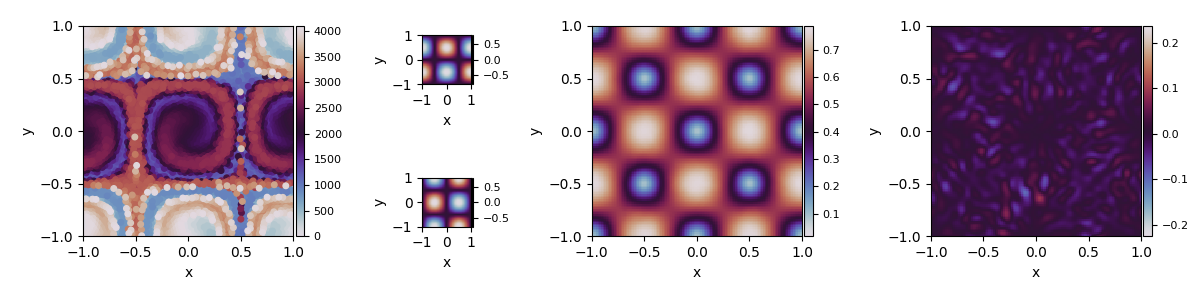

In [165]:
s = 16
fig, axis = plt.subplot_mosaic(\
'''AADBBCC
AAEBBCC''', figsize=(12,3), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)

plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, perennialState['fluidIndex'] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
plotVelUIndex = visualizeParticles(fig, axis['D'], config, visualizationState, perennialState['fluidVelocities'][:,0] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
plotVelVIndex = visualizeParticles(fig, axis['E'], config, visualizationState, perennialState['fluidVelocities'][:,1] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
plotVelMagIndex = visualizeParticles(fig, axis['B'], config, visualizationState, torch.norm(perennialState['fluidVelocities'], dim = 1) , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
plotDivergenceIndex = visualizeParticles(fig, axis['C'], config, visualizationState, perennialState['fluidDivergence'] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')

fig.tight_layout()

0.5452003 1.4137055


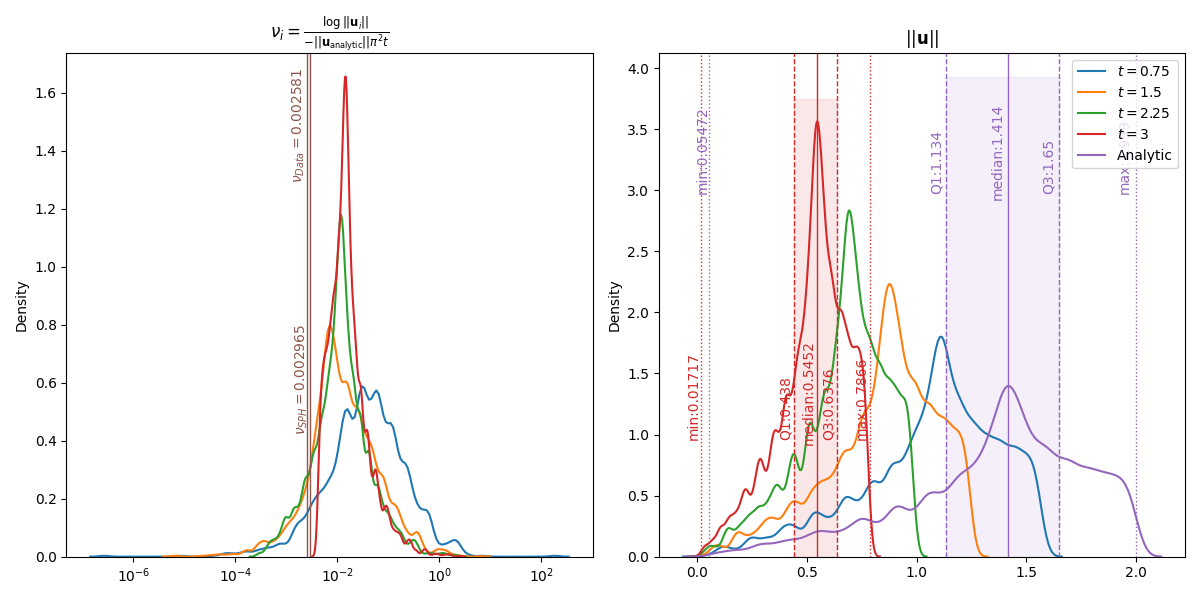

In [175]:
import seaborn as sns


minDomain = config['domain']['minExtent']
maxDomain = config['domain']['maxExtent']
# periodicity = config['domain']['periodic']
x = perennialState['fluidPositions']
periodicity = torch.tensor([config['domain']['periodic']] * x.shape[1], dtype = torch.bool).to(x.device)
positions = torch.stack([x[:,i] if not periodic_i else torch.remainder(x[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)

analyticVelocities = torch.clone(perennialState['fluidVelocities'])
analyticVelocities[:,0] =  2 * torch.cos(k * positions[:,0]) * torch.sin(k * positions[:,1])
analyticVelocities[:,1] = -2 * torch.sin(k * positions[:,0]) * torch.cos(k * positions[:,1])


nu_max = torch.log(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1).max()) /(-2 * np.pi**2 * perennialState['time'])
nu = (torch.log(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)) /(-torch.linalg.norm(analyticVelocities, dim = -1) * np.pi**2 * perennialState['time'])).detach().cpu().numpy()
nu_sph = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support'] / (2 * (config['domain']['dim'] +2))
nu_sph = config['diffusion']['nu'] if config['diffusion']['velocityScheme'] == 'deltaSPH_viscid' else nu_sph


fig, ax = plt.subplots(1, 2, figsize = (12,6), squeeze = False)



median_velocity = torch.median(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)).detach().cpu().numpy()
median_analytic = torch.median(torch.linalg.norm(analyticVelocities, dim = -1)).detach().cpu().numpy()
print(median_velocity, median_analytic)

# median_velocity = torch.median(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)).detach().cpu().numpy()
viscosity = np.log(median_velocity) / (-median_analytic * np.pi**2 * perennialState['time'])

nu_data = np.log(torch.max(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)).detach().cpu().numpy()) / (-k * np.pi**2 * perennialState['time'])
# print(viscosity)
# print(np.median(nu))

ax[0,0].set_title(r'$\nu_i = \frac{\log{||\mathbf{u}_i||}}{- ||\mathbf{u}_{\text{analytic}}|| \pi^2 t}$')
ax[0,1].set_title(r'$||\mathbf{u}||$')

def plotStatistics(ax, data, color, offset = 0):
    ax.axvline(np.median(data), color = color, lw = 1, ls = '-')
    ax.text(np.median(data)*0.99, ax.get_ylim()[1]/4 + offset, f'median:{np.median(data):.4g}', color = color, ha = 'right', rotation = 90)

    q1, q3 = np.percentile(data, [25,75])
    ax.axvline(q1, color = color, lw = 1, ls = '--')
    ax.axvline(q3, color = color, lw = 1, ls = '--')
    ax.fill_betweenx(ax.get_ylim(), q1, q3, color = color, alpha = 0.1)
    ax.text(q1*0.99, ax.get_ylim()[1]/4 + offset, f'Q1:{q1:.4g}', color = color, ha = 'right', rotation = 90)
    ax.text(q3*0.99, ax.get_ylim()[1]/4 + offset, f'Q3:{q3:.4g}', color = color, ha = 'right', rotation = 90)
    
    ax.axvline(np.max(data), color = color, lw = 1, ls = ':')
    ax.axvline(np.min(data), color = color, lw = 1, ls = ':')
    ax.text(np.max(data)*0.99, ax.get_ylim()[1]*1/4 + offset, f'max:{np.max(data):.4g}', color = color, ha = 'right', rotation = 90)
    ax.text(np.min(data)*0.99, ax.get_ylim()[1]*1/4 + offset, f'min:{np.min(data):.4g}', color = color, ha = 'right', rotation = 90)

for state in savedStates:
    x = state['fluidPositions']
    positions = torch.stack([x[:,i] if not periodic_i else torch.remainder(x[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)

    analyticVelocities[:,0] =  2 * torch.cos(k * positions[:,0]) * torch.sin(k * positions[:,1])
    analyticVelocities[:,1] = -2 * torch.sin(k * positions[:,0]) * torch.cos(k * positions[:,1])
    nu = (torch.log(torch.linalg.norm(state['fluidVelocities'], dim = -1)) /(-torch.linalg.norm(analyticVelocities, dim = -1) * np.pi**2 * state['time'])).detach().cpu().numpy()

    hist = sns.kdeplot(nu, ax = ax[0,0], log_scale= True, bw_adjust = 0.5, label = rf'$t = {{:.3g}}$'.format(state['time']))
    sns.kdeplot(torch.linalg.norm(state['fluidVelocities'], dim = -1).detach().cpu().numpy(), ax = ax[0,1], label = rf'$t = {{:.3g}}$'.format(state['time']), bw_adjust = 0.5)



sns.kdeplot(torch.linalg.norm(analyticVelocities, dim = -1).detach().cpu().numpy(), ax = ax[0,1], label = 'Analytic', bw_adjust = 0.5)


ax[0,1].legend()
# plotStatistics(ax[0,0], nu, sns.color_palette()[len(savedStates) - 1], offset = ax[0,0].get_ylim()[1]/2)
plotStatistics(ax[0,1], torch.linalg.norm(perennialState['fluidVelocities'], dim = -1).detach().cpu().numpy(), sns.color_palette()[len(savedStates) - 1])
plotStatistics(ax[0,1], torch.linalg.norm(analyticVelocities, dim = -1).detach().cpu().numpy(), sns.color_palette()[len(savedStates)], offset = ax[0,1].get_ylim()[1]/2)

ax[0,0].axvline(nu_sph.detach().cpu().numpy(), color = sns.color_palette()[len(savedStates) + 1], lw = 1, ls = '-')
ax[0,0].text(nu_sph.detach().cpu().numpy()*0.99, ax[0,0].get_ylim()[1]/4, f'$\\nu_{{SPH}} = {nu_sph:.4g}$', color = sns.color_palette()[len(savedStates) + 1], ha = 'right', rotation = 90)

ax[0,0].axvline(nu_data, color = sns.color_palette()[len(savedStates) + 1], lw = 1, ls = '-')
ax[0,0].text(nu_data*0.99, ax[0,0].get_ylim()[1]*3/4, f'$\\nu_{{Data}} = {nu_data:.4g}$', color = sns.color_palette()[len(savedStates) + 1], ha = 'right', rotation = 90)
fig.tight_layout()

In [180]:
Re = 2 * k / nu_data
print(Re)
Re = 2 * k / nu_sph
print(Re)

Re = 2 * k / np.median(nu)
print(Re)

2434.3268208544678
tensor(2119.3784, device='cuda:0')
432.98001810732643


<Axes: title={'center': '$\\nu_i$'}, ylabel='Count'>

In [10]:
import subprocess
import shlex

command = '/usr/bin/ffmpeg -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r 30 ' + outFolder + 'output.mp4'

# command = '/usr/bin/ffmpeg -hide_banner -y -r 60 -i ' + outFolder + 'frame_%04d.png -c:v libx264 -vf "fps=60,format=yuv420p" ' + outFolder + 'output.mp4'
subprocess.run(shlex.split(command))

import shlex

commandA = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -vf "fps=30,scale=1280:-1:flags=lanczos,palettegen" {outFolder}palette.png'
commandB = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -i {outFolder}palette.png -filter_complex "fps=30,scale=1280:-1:flags=lanczos[x];[x][1:v]paletteuse" squarePatch.gif'

subprocess.run(shlex.split(commandA))
subprocess.run(shlex.split(commandB))

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

CompletedProcess(args=['ffmpeg', '-hide_banner', '-y', '-i', './output/2024_03_06-15_31_28/output.mp4', '-i', './output/2024_03_06-15_31_28/palette.png', '-filter_complex', 'fps=30,scale=1280:-1:flags=lanczos[x];[x][1:v]paletteuse', 'squarePatch.gif'], returncode=0)

<img src = "./squarePatch.gif" width = 500/>